In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Load processed data
df = pd.read_csv("processed_data.csv")

# Train-test split (time-aware)

In [13]:
X = df.drop(columns=["aqi_index", "datetime", "date_ist", "time_ist", "condition_text", "description"])
y = df["aqi_index"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Baseline Model


In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# Random Forest Model

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation Function

In [15]:
def evaluate(y_true, y_pred, name):
    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2:", r2_score(y_true, y_pred))

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")


Linear Regression
MAE: 0.8751215851206859
RMSE: 1.7241477989004563
R2: 0.9996745628691519

Random Forest
MAE: 0.567453913141331
RMSE: 0.8398674631508486
R2: 0.9999227782513277


# Prediction Visualization

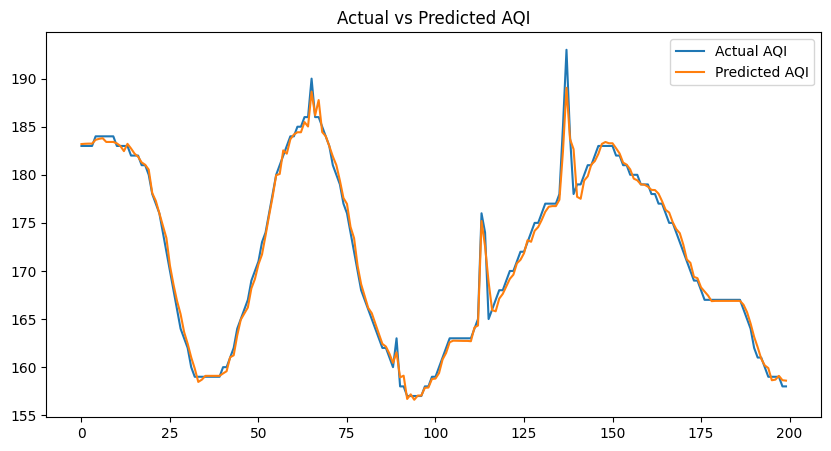

In [17]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label="Actual AQI")
plt.plot(y_pred_rf[:200], label="Predicted AQI")
plt.legend()
plt.title("Actual vs Predicted AQI")
plt.show()

# Feature Importance

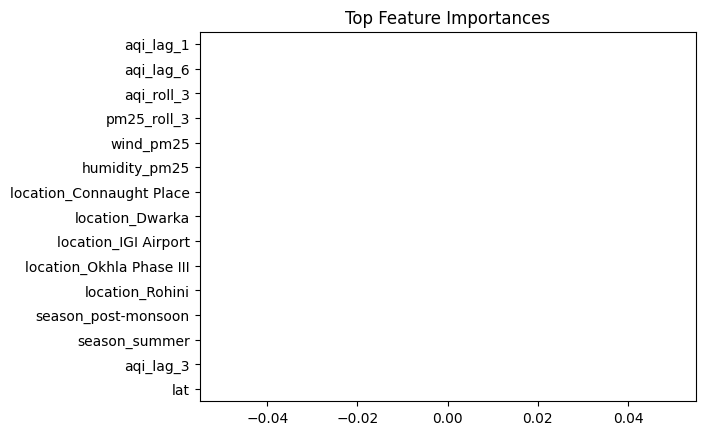

In [16]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind="barh")
plt.title("Top Feature Importances")
plt.show()


# Optimized Random Forest

In [18]:

# -------------------------
# 1. Create a representative subset for tuning
# -------------------------

# Use 10k–15k samples for fast tuning
sample_size = 15000
df_sample = df.sample(sample_size, random_state=42)

X_sample = df_sample[X.columns]
y_sample = df_sample["aqi_index"]

## 2. Define Random Forest model

In [19]:
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

## 3. Reduced parameter grid (fast but effective)


In [21]:
param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

## 4. RandomizedSearchCV (fast configuration)


In [22]:
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=5,                     # fewer iterations
    cv=2,                         # fewer folds
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)


## 5. Fit on subset (FAST)

In [24]:
# -------------------------
# -------------------------

rf_search.fit(X_sample, y_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 15], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [200, 300]}"
,n_iter,5
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [25]:
# Best estimator from tuning
best_rf = rf_search.best_estimator_

print("Best RF Parameters:")
print(rf_search.best_params_)

# -------------------------
# 6. Retrain best model on FULL training data
# -------------------------

best_rf.fit(X_train, y_train)

# -------------------------
# 7. Evaluate on test set
# -------------------------

y_pred_rf_tuned = best_rf.predict(X_test)

def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))

evaluate(y_test, y_pred_rf_tuned, "Tuned Random Forest")

Best RF Parameters:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15}

Tuned Random Forest
MAE: 0.5891265131030115
RMSE: 0.9056332796049855
R²: 0.9999102110557955


In [26]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost")



XGBoost
MAE: 1.4328875541687012
RMSE: 2.3804096050570585
R²: 0.9993796944618225


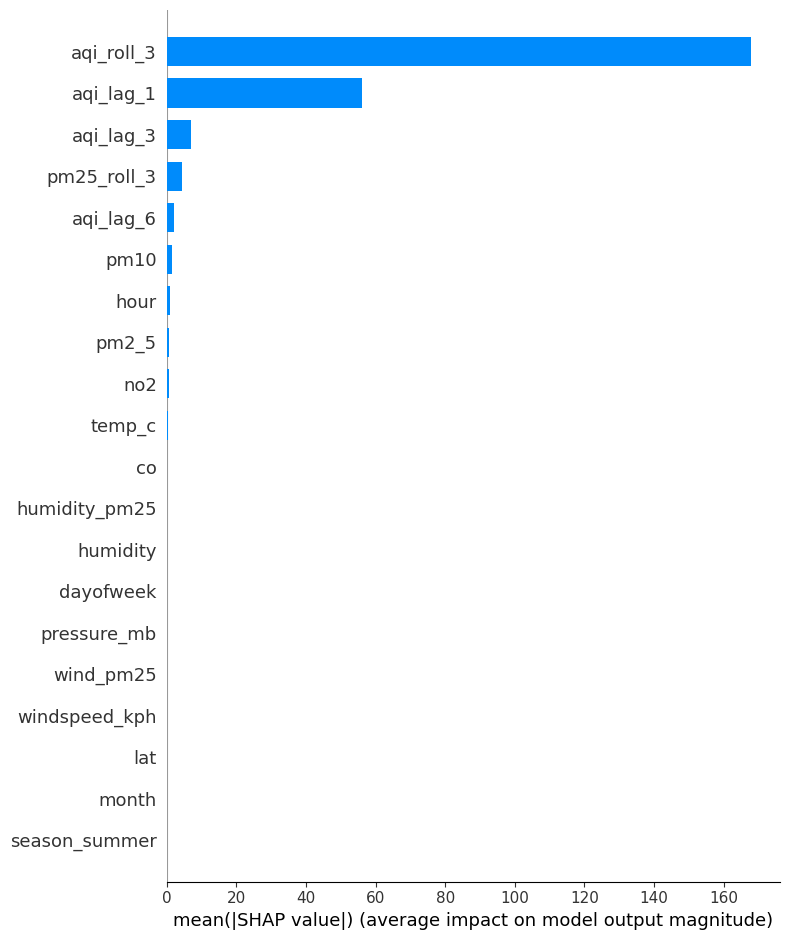

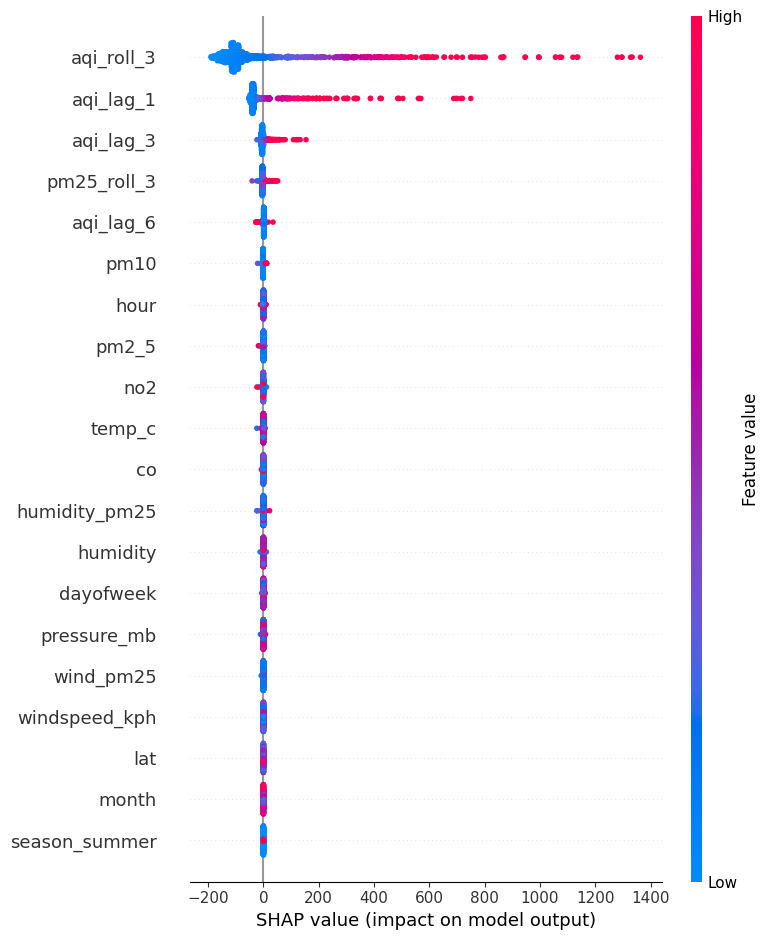

In [29]:
# =========================
# SHAP Explainability
# =========================

import shap
import numpy as np

# -------------------------
# 1. Take a sample for speed
# -------------------------

X_sample = X_train.sample(1000, random_state=42)

# -------------------------
# 2. Convert to pure NumPy float array
#    (CRITICAL STEP to avoid dtype errors)
# -------------------------

X_sample_np = X_sample.to_numpy(dtype=np.float64)

feature_names = X_sample.columns.tolist()

# -------------------------
# 3. Create TreeExplainer
# -------------------------

explainer = shap.TreeExplainer(xgb)

# -------------------------
# 4. Compute SHAP values
# -------------------------

shap_values = explainer.shap_values(X_sample_np)

# -------------------------
# 5. Global Feature Importance (Bar Plot)
# -------------------------

shap.summary_plot(
    shap_values,
    X_sample_np,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# -------------------------
# 6. Detailed SHAP Summary Plot
# -------------------------

shap.summary_plot(
    shap_values,
    X_sample_np,
    feature_names=feature_names,
    show=True
)


In [28]:
X_train.dtypes[X_train.dtypes == "object"]


Series([], dtype: object)

In [30]:
xgb.save_model("xgb_model.json")


In [31]:
import joblib

joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")
xgb.save_model("xgb_model.json")
